In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from phantom_functions import create_ptycho_phantom, calculate_wavelength, read_probe_positions_new, convert_positions_to_pixels,set_object_size_pxls, load_data, get_simulated_data, read_probe_positions_in_pxls
from ptycho_functions import RAAR_loop, mPIE_loop,RAAR_multiprobe_loop,PIE_multiprobe_loop, plot_results3, plot_probe_modes, plot_guess_and_model, get_circular_mask

In [ ]:
inputs = {
"path" : "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho3d/complex_phantom/",
"matrix_size": 50, # n of pixels; one side of cube
"n_cpus": 100, # cpu cores
"energy": 6, #keV
"distance": 1, # meter
"detector_pixel": 8*1.25156e-6,
"probe_steps_xy": [10,10], # pixels
"n_of_angles": 0
}

iterations = 100
n_of_modes = 1

if 1: # dummy sample
    
    diffraction_patterns, positions, model_obj, model_probe, positions_errors = get_simulated_data(inputs["probe_steps_xy"],random_positions=False,add_position_errors=False,dimension=200, object_offset = 5)
  
    """ Experiment Parameters """
    c_speed = 299792458        # Velocity of Light [m/s]
    planck  = 4.135667662E-18  # Plank constant [keV*s]
    position_step = np.max([positions[i]-positions[i-1] for i in range(1,len(positions))])*1e-6
    distance = 30  # meters
    energy = 10    # keV
    n_pixels = 3072
    pixel_size = 55.13e-6  # meters
    wavelength = c_speed * planck / energy
    dx = wavelength*distance/(n_pixels*pixel_size)
    oversampling_ratio = wavelength*distance/(position_step*pixel_size)
    print('Object pixel size:',dx)
    print("Oversampling: ",oversampling_ratio)
    experiment_params = dx, wavelength,distance
    # probe_guess = model_probe*np.exp(-1j*model_probe*2)  
    probe_guess = get_circular_mask(model_probe.shape[0],0.3)
    probe_guess = np.abs(probe_guess)*np.exp(1j*probe_guess)
    # probe_guess = np.ones_like(probe_guess) 
    obj_guess = np.ones_like(model_obj) # constant object
    obj_guess = np.random.rand(model_obj.shape[0],model_obj.shape[1])+1j
    
else: # complex phantom
    
    offset = 50
    POSITION_ERROR = 0
    phantom, magnitude, phase, sinogram, probe, data = create_ptycho_phantom(inputs,sample="donut",probe_type="CAT",offset=offset,position_errors=POSITION_ERROR,load=True,preview=True) # run with load = False first; this will create data; then you can run with load = True 
    
    data_folder = "/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/ptycho3d/"
    dataname = "complex_phantom"
        
    diffraction_patterns, positions, model_obj, model_probe, obj_pixel_size, wavelength,distance = load_data(data_folder,dataname,offset)

    experiment_params = obj_pixel_size, wavelength,distance
    
    """ Initial guesses """
    object_shape = set_object_size_pxls( positions[:,0], positions[:,1],model_probe.shape,border=offset)
    obj_guess = np.random.rand(object_shape[0],object_shape[1])+1j
    # obj_guess = np.ones_like(obj_guess)
    
    # probe_guess = model_probe #np.roll(model_probe,(0,10))
    probe_guess = np.ones(model_probe.shape)
    # probe_guess = np.random.rand(*model_probe.shape)
    # probe_guess = get_circular_mask(model_probe.shape[0],0.7)#*np.random.rand(*model_probe.shape)

plot_guess_and_model(model_obj,model_probe,obj_guess,probe_guess,positions)

Starting PIE...
	Iteration 0/100
	Iteration 25/100
	Iteration 50/100
	Iteration 75/100
Starting RAAR...
	Iteration 0/100
	Iteration 50/100
Starting multiprobe RAAR...
	Iteration 0/100
	Iteration 50/100
RAAR algorithm ended in 4.3086377289146185 seconds
Starting multiprobe PIE algorithm...
	Iteration 0/100
	Iteration 50/100
PIE algorithm ended in 6.0989114050753415 seconds


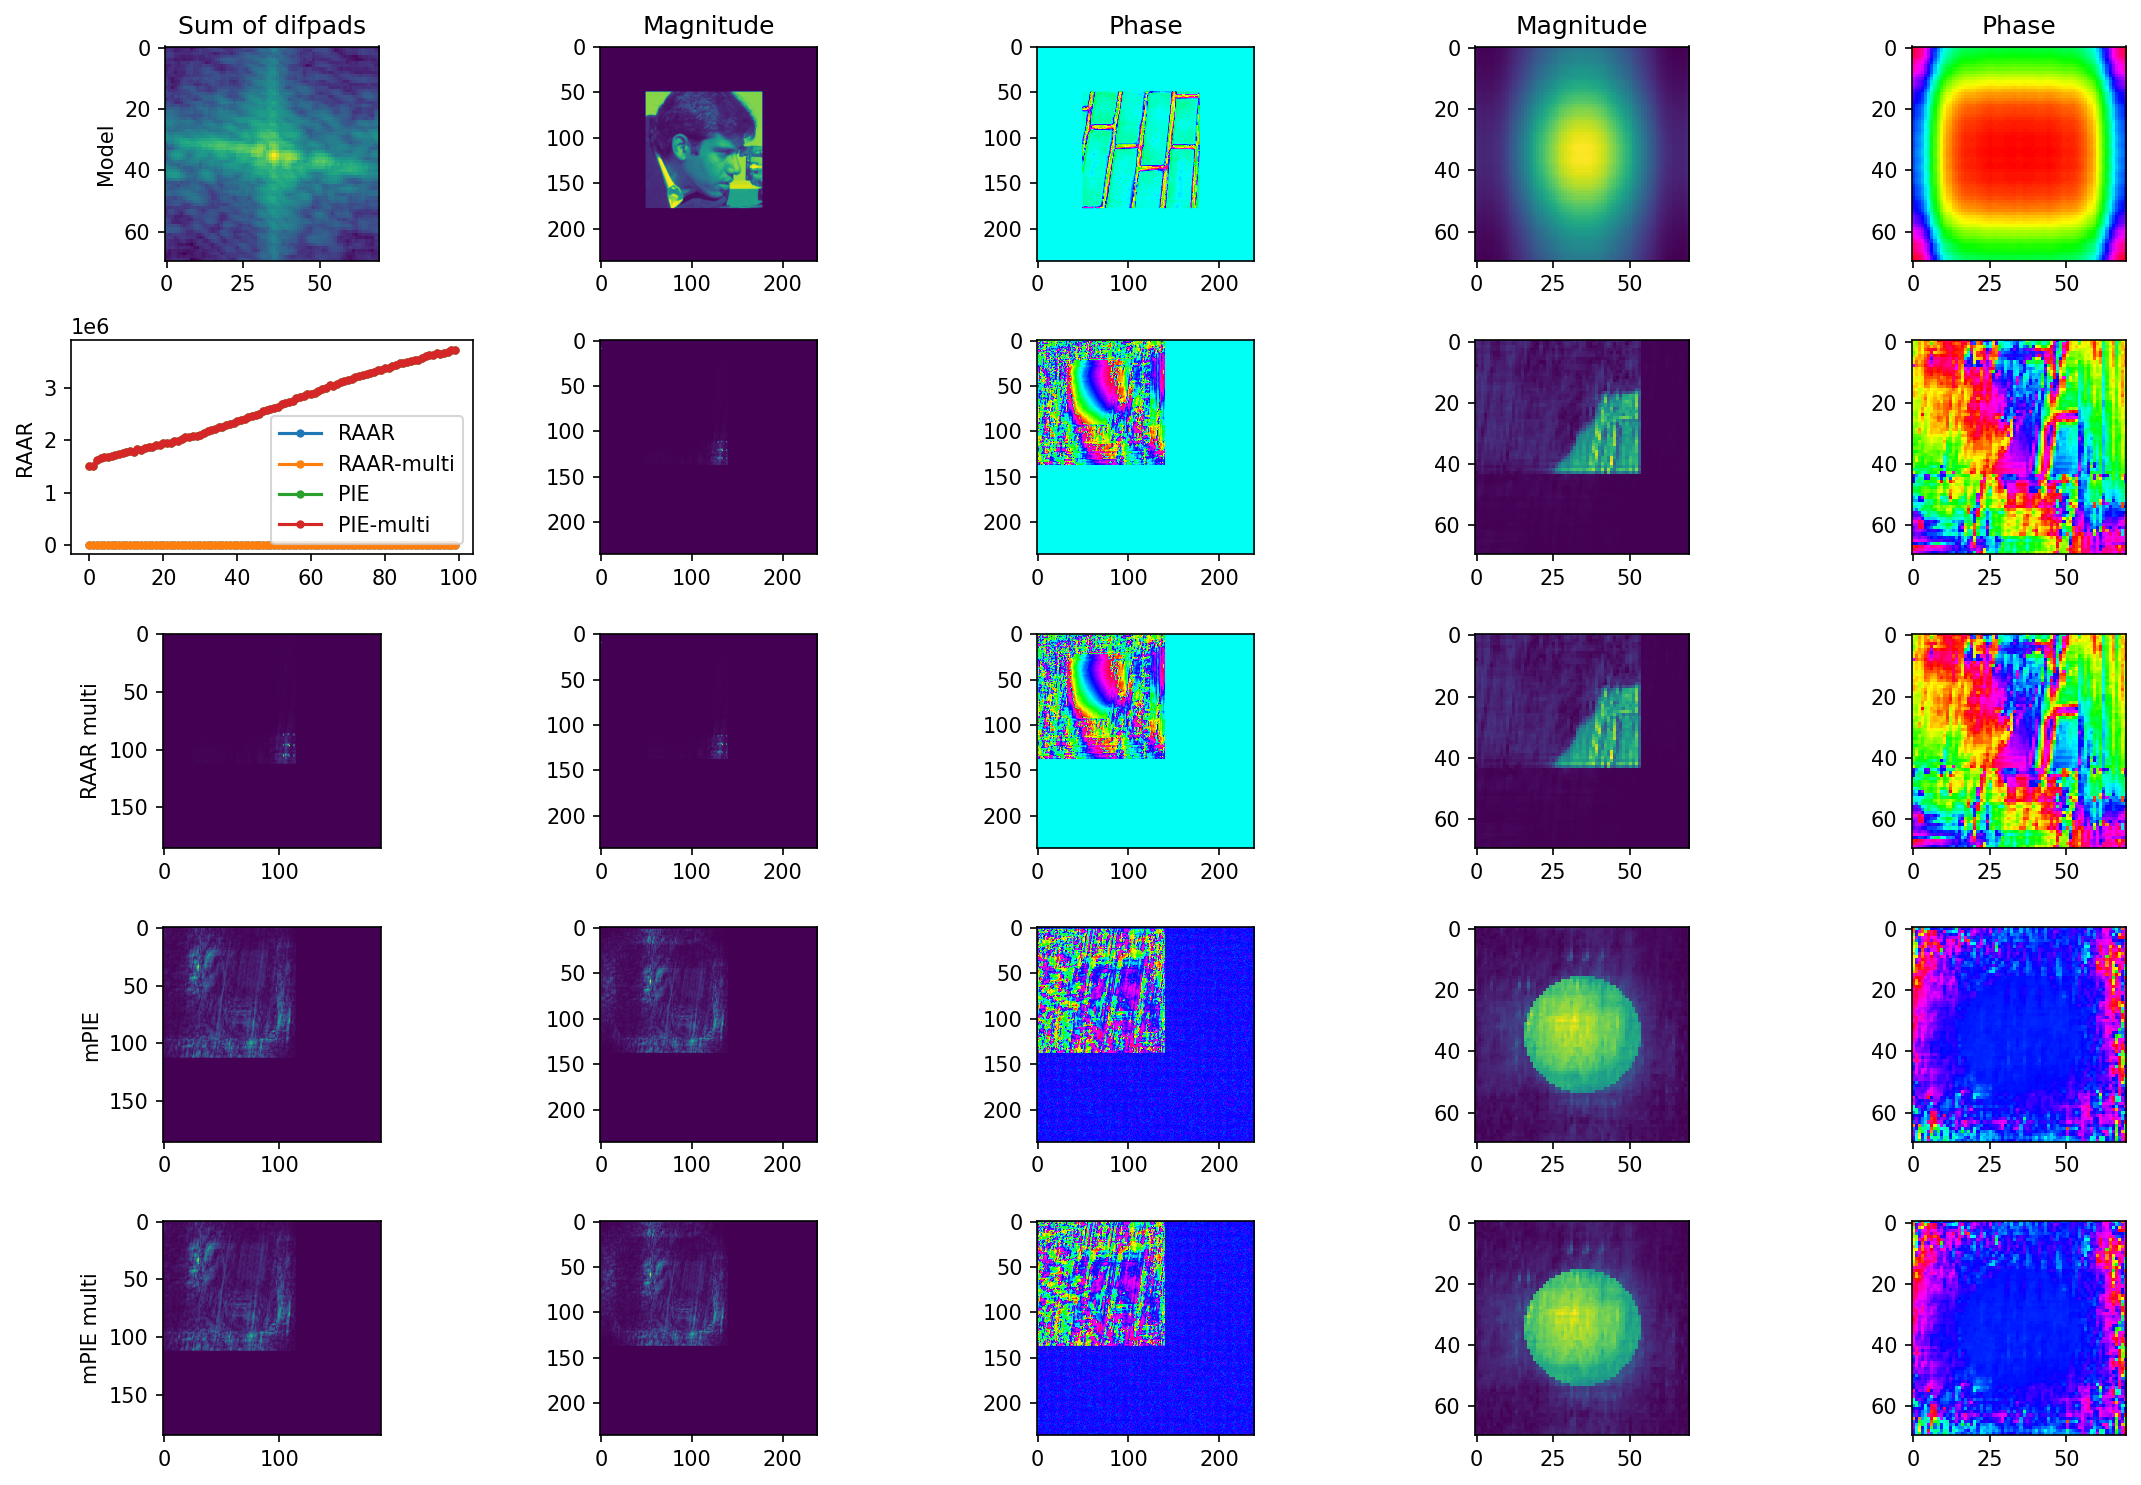

In [6]:
if 1: 
    """ mPIE """
    if 0: # suggested min from paper
        regularization_object, regularization_probe = 0.05, 0.5
        step_object, step_probe = 0.1, 0.2
        friction_object, friction_probe = 0.5, 0.75
        momentum_counter = 10
    elif 0: # suggested max from paper
        regularization_object, regularization_probe = 0.25, 5
        step_object, step_probe = 0.5, 1
        friction_object, friction_probe = 0.9, 0.99
        momentum_counter = 100 
    else: # my params
        regularization_object, regularization_probe = 0.25, 5
        step_object, step_probe = 0.5, 0.1
        friction_object, friction_probe = 0.9, 0
        momentum_counter = 100 

    centralize_probe = False
    mPIE_params = (regularization_object,regularization_probe,step_object,step_probe,friction_object,friction_probe,momentum_counter)
    PIE_obj, PIE_probe, PIE_positions, PIE_error, PIE_time, positions_story = mPIE_loop(diffraction_patterns, positions.copy(),obj_guess.copy(),probe_guess, mPIE_params, experiment_params, iterations, model_obj,centralize_probe,beta=300)

if 1: 
    """ RAAR """
    beta = 0.995
    epsilon = 0.01
    RAAR_params = (beta,epsilon)
    RAAR_obj, RAAR_probe, RAAR_error, RAAR_time = RAAR_loop(diffraction_patterns,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj)

if 1:
    """ multiprobe RAAR """
    RAAR_params = (beta,epsilon)
    RAAR2_obj, RAAR2_probes, RAAR2_error, RAAR2_time = RAAR_multiprobe_loop(diffraction_patterns,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj,n_of_modes=n_of_modes)
    RAAR2_probe = RAAR2_probes[0]


if 1:
    """ multiprobe mPIE """
    mPIE_params = {}
    mPIE_params["regularization_object"] = regularization_object
    mPIE_params["regularization_probe"]  = regularization_probe
    mPIE_params["step_object"]           = step_object
    mPIE_params["step_probe"]            = step_probe
    mPIE_params["friction_object"]       = friction_object
    mPIE_params["friction_probe"]        = friction_probe
    mPIE_params["momentum_counter"]      = momentum_counter
    PIE2_obj, PIE2_multiprobe, PIE2_error, PIE2_time  = PIE_multiprobe_loop(diffraction_patterns, positions, iterations, mPIE_params, model_obj,n_of_modes = n_of_modes, object_guess=obj_guess.copy(), probe_guess=probe_guess, use_momentum = True)
    PIE2_obj = PIE2_obj[0]
    PIE2_probe = PIE2_multiprobe[0]


# RAAR_obj, RAAR_probe, RAAR_error, RAAR_time    =        PIE_obj, PIE_probe, PIE_error, PIE_time
RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time  = RAAR_obj, RAAR_probe, RAAR_error, RAAR_time   
PIE2_obj, PIE2_probe, PIE2_error, PIE2_time = PIE_obj, PIE_probe, PIE_error, PIE_time

plot_results3(diffraction_patterns,model_obj,model_probe,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time,PIE2_obj, PIE2_probe, PIE2_error, PIE2_time, RAAR2_obj, RAAR2_probe, RAAR2_error, RAAR2_time, axis=True )

# plot_probe_modes(RAAR2_probes)
# plot_probe_modes(PIE2_multiprobe)

plt.show()


In [ ]:
def plot_positions_and_errors(data_folder,dataname,offset,PIE_positions=[],positions_story=[]):
    
    import os, json
    
    metadata = json.load(open(os.path.join(data_folder,dataname,'mdata.json')))
    distance = metadata['/entry/beamline/experiment']['distance']*1e-3
    energy = metadata['/entry/beamline/experiment']['energy']
    pixel_size = metadata['/entry/beamline/detector']['pimega']['pixel size']*1e-6
    wavelength, wavevector = calculate_wavelength(energy)
    
    diffraction_patterns = np.load(os.path.join(data_folder,dataname,f"0000_{dataname}_001.hdf5.npy"))

    n_pixels = diffraction_patterns.shape[1]
    obj_pixel_size = wavelength*distance/(n_pixels*pixel_size)
    
    _,_,measured = read_probe_positions_in_pxls(os.path.join(data_folder,dataname),f"0000_{dataname}",obj_pixel_size,offset,0)
    _,_,true = read_probe_positions_in_pxls(os.path.join(data_folder,dataname),f"0000_{dataname}_without_error",obj_pixel_size,offset,0)
    
    colors = np.linspace(0,positions.shape[0]-1,positions.shape[0])
    fig, ax = plt.subplots(dpi=150)
    ax.legend(["True" , "Measured", "Corrected", "Path"],loc=(1.05,0.84))    
    ax.scatter(measured[:,1],measured[:,0],marker='o',c='red')#,c=np.linspace(0,positions.shape[0]-1,positions.shape[0]),cmap='jet')
    if positions_story != []:
        for i in range(PIE_positions.shape[0]):
            y = positions_story[:,i,1]
            x = positions_story[:,i,0]
            ax.scatter(y,x,color='blue',s=2,marker=',',alpha=0.2)
    if PIE_positions != []:
        ax.scatter(PIE_positions[:,1],PIE_positions[:,0],marker='x',color='blue')#,c=np.linspace(0,positions.shape[0]-1,positions.shape[0]),cmap='jet')
    ax.scatter(true[:,1],true[:,0],marker='*',color='green')#,c=colors,cmap='jet')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.grid()
    
plot_positions_and_errors(data_folder,dataname,offset,PIE_positions,positions_story)